# 4c. Improving the training loop

Now that we are able to compute the loss for our training data, we are able to train the model with the same couple of steps that we have encountered at the end of [**Notebook 2**](../2_Tensors/2b_Tensors_features_Solution.ipynb).

We will take this as a starting point to introduce the `torch.optim` package which provides us with the `Optimizer` API that greatly simplifies the training loop.

## Key concepts of this section

1. `Optimizer` API from the `torch.optim` package

In [1]:
import random
import collections
import math
from typing import Tuple, List

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from intro_to_pytorch import data
import helper

## Training loop so far

Going back to the last section of [**Notebook 4b**](4b_loss_functions_Solutions.ipynb), we finished by calculating the per batch loss.

In [2]:
# Nothing new here, just repeating definitions for clarity ... don't do this at home!

class MnistDataSet:
    def __init__(self, train=True):
        subset = "training" if train else "test"
        self.x, self.y = torch.load(data.DATA_PATH / f"MNIST/processed/{subset}.pt")
        self.x = self.x.float()
    
    def __getitem__(self, key) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[key], self.y[key]
    
    def __len__(self):
        return len(self.x)
    
class MnistDataLoader:
    def __init__(self, dataset, batch_size, shuffle, transform=None):
        self.dataset, self.batch_size, self.shuffle, self.transform = dataset, batch_size, shuffle, transform
    
    def __iter__(self):
        self.idx = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.idx)
        return self
    
    def __next__(self):
        if self.idx:
            batch, self.idx = self.idx[:self.batch_size], self.idx[self.batch_size:]
            x, y = self.dataset[batch]
            if self.transform:
                return self.transform(x, y)
            return x, y
        
        raise StopIteration()

class ImageNormalizer:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
    
    def __call__(self, x, y):
        return (x - self.mean).div_(self.std), y

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)
        

def get_model():
    return torch.nn.Sequential(collections.OrderedDict([
        ("reshape", Flatten()),
        ("hidden", torch.nn.Linear(28*28,256)),
        ("sigmoid", torch.nn.Sigmoid()),
        ("output", torch.nn.Linear(256,10)),
      ]))

In [3]:
train_dl = MnistDataLoader(MnistDataSet(train=True), 1024, True, ImageNormalizer(33.32, 78.57))
test_dl = MnistDataLoader(MnistDataSet(train=False), 1024, True, ImageNormalizer(33.32, 78.57))
ce = torch.nn.CrossEntropyLoss()

def accuracy(preds, target):
    return (preds.max(-1)[1] == target).float().mean()

# for x, y in train_dl:
#     preds = model(x)
#     print(ce(preds, y))
#     print(accuracy(preds, y))
        

In [**Notebook 2**](../2_Tensors/2b_Tensors_features_Solution.ipynb) we already saw such a loop when finding the parameters for a **linear fit** to some data by minimizing the **MSE**.

Let's us try to reproduce this algorithm with our current setup!

In [4]:
def train_nn(model, n_epochs, lr):
    train_losses = np.array([])
    test_losses = np.array([])
    accuracies = np.array([])

    for epoch in range(n_epochs):
        for x, y in train_dl:
            train_loss = ce(model(x), y)
            train_loss.backward()
            train_losses = np.append(train_losses, train_loss.item())

            with torch.no_grad():
                for p in model.parameters():
                    p += - lr * p.grad
                    p.grad.data.zero_()

        test_loss, acc = evaluate_nn(model, test_dl)
        test_losses = np.append(test_losses, test_loss)
        accuracies = np.append(accuracies, acc)

        print(f"Epoch: {epoch} \t Training loss: {train_losses[-1]} \t Test loss: {test_losses[-1]} \t Test accurarcy: {accuracies[-1]}")
    return train_losses, test_losses, accuracies

def evaluate_nn(model, test_dl):
    preds = torch.tensor([])
    targets = torch.tensor([]).long()
    
    with torch.no_grad():
        for x, y in test_dl:
            targets = torch.cat([targets, y])
            preds = torch.cat([preds, model(x)])
        test_loss = ce(preds, targets)
    return test_loss.item(), accuracy(preds, targets).item()

def plot_metrics(train_losses, test_losses, accuracies):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    
    x = np.array(range(len(train_losses)))
    iterations_per_epoch = int(len(train_losses)/ len(test_losses))
    x_val = x[iterations_per_epoch - 1 :: iterations_per_epoch]
    ax0.plot(x, train_losses, label='train')
    ax0.plot(x_val, test_losses, label='test')
   
    ax0.legend()
    ax0.set_ylabel("Loss")
    ax0.set_xlabel("Iteration")
    
    ax1.set_ylabel("Accuracy")
    ax1.plot(x_val, accuracies)
    ax1.set_xlabel("Iteration")
    plt.tight_layout()

Epoch: 0 	 Training loss: 2.158369779586792 	 Test loss: 2.1527888774871826 	 Test accurarcy: 0.5142999887466431
Epoch: 1 	 Training loss: 1.9965535402297974 	 Test loss: 1.995869517326355 	 Test accurarcy: 0.6248999834060669
Epoch: 2 	 Training loss: 1.8434574604034424 	 Test loss: 1.8364449739456177 	 Test accurarcy: 0.7081999778747559
Epoch: 3 	 Training loss: 1.6874278783798218 	 Test loss: 1.6776529550552368 	 Test accurarcy: 0.7282999753952026
Epoch: 4 	 Training loss: 1.514965295791626 	 Test loss: 1.525589108467102 	 Test accurarcy: 0.7565000057220459
Epoch: 5 	 Training loss: 1.3947172164916992 	 Test loss: 1.3865190744400024 	 Test accurarcy: 0.7768999934196472
Epoch: 6 	 Training loss: 1.2802985906600952 	 Test loss: 1.2631876468658447 	 Test accurarcy: 0.79339998960495
Epoch: 7 	 Training loss: 1.162083387374878 	 Test loss: 1.1567317247390747 	 Test accurarcy: 0.8051000237464905
Epoch: 8 	 Training loss: 1.1039177179336548 	 Test loss: 1.065488338470459 	 Test accurarcy: 0

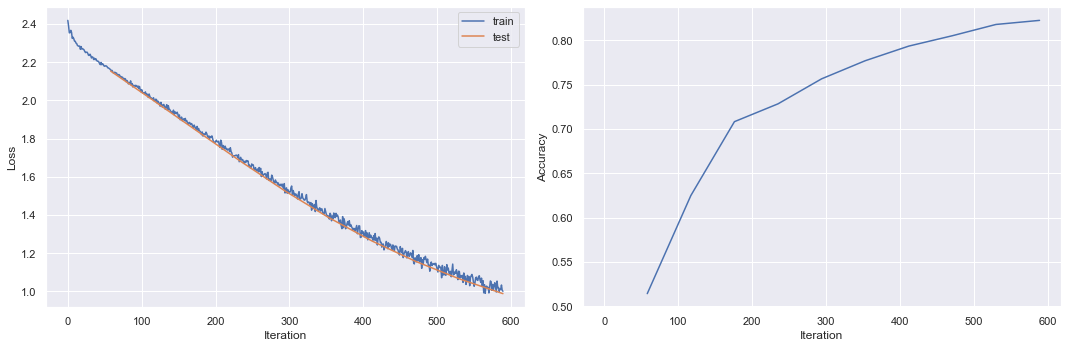

In [5]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, n_epochs=10, lr=0.01)
plot_metrics(train_losses, test_losses, accuracies)

## PyTorch Optimizers

The above is a very neat example. The actual training code is only the part from l.6 to l.15, while the rest is mainly for logging.

However, it looks like the part from l.12 to l.15 is very generic and it can certainly be refactored away:

In [6]:
class Optimizer:
    def __init__(self, parameters, lr):
        self.parameters, self.lr = list(parameters), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p += - self.lr * p.grad
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.parameters:
                if p.grad is not None:
                    p.grad.data.zero_()
                
                
def train_nn(model, optim, n_epochs):
    train_losses = np.array([])
    test_losses = np.array([])
    accuracies = np.array([])

    for epoch in range(n_epochs):
        for x, y in train_dl:
            
            train_loss = ce(model(x), y)
            train_loss.backward()
            train_losses = np.append(train_losses, train_loss.item())

            optim.step()
            optim.zero_grad()

        test_loss, acc = evaluate_nn(model, test_dl)
        test_losses = np.append(test_losses, test_loss)
        accuracies = np.append(accuracies, acc)
        
        print(f"Epoch: {epoch} \t Training loss: {train_losses[-1]} \t Test loss: {test_losses[-1]} \t Test accurarcy: {accuracies[-1]}")
    return train_losses, test_losses, accuracies

Epoch: 0 	 Training loss: 2.1378891468048096 	 Test loss: 2.140251636505127 	 Test accurarcy: 0.5396999716758728
Epoch: 1 	 Training loss: 1.9988447427749634 	 Test loss: 1.9814538955688477 	 Test accurarcy: 0.6438999772071838
Epoch: 2 	 Training loss: 1.832958459854126 	 Test loss: 1.8210660219192505 	 Test accurarcy: 0.6995000243186951
Epoch: 3 	 Training loss: 1.6987035274505615 	 Test loss: 1.6616544723510742 	 Test accurarcy: 0.7311999797821045
Epoch: 4 	 Training loss: 1.5630829334259033 	 Test loss: 1.51112961769104 	 Test accurarcy: 0.7519000172615051
Epoch: 5 	 Training loss: 1.3743939399719238 	 Test loss: 1.374288558959961 	 Test accurarcy: 0.7694000005722046
Epoch: 6 	 Training loss: 1.2897043228149414 	 Test loss: 1.2543883323669434 	 Test accurarcy: 0.7861999869346619
Epoch: 7 	 Training loss: 1.191753625869751 	 Test loss: 1.1510260105133057 	 Test accurarcy: 0.8003000020980835
Epoch: 8 	 Training loss: 1.054255485534668 	 Test loss: 1.062766432762146 	 Test accurarcy: 0

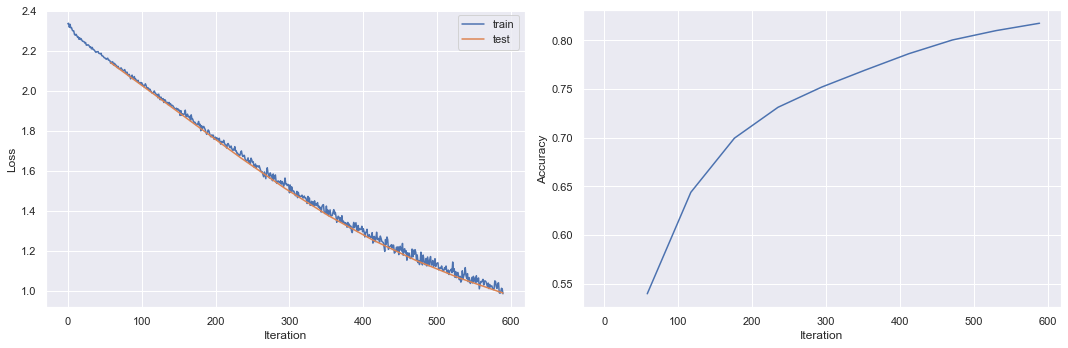

In [16]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, Optimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model.state_dict(), "../data/model.pt")

This basically introduces the core of what the [torch.optim.Optimizer](https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer) does. 

The `torch.optim` package, however, does not only offer an almost empty capsule for updating model parameters - it has all the deep learning batteries included: in our simple case, the weight update is performed with the **SGD** rule: 
$$\omega_t = \omega_{t-1} - \lambda * \nabla \omega$$

Much more advanced algorithms exist to perform the weight update, like **SGD with momentum**, **Adagrad**, **Adam**, ...

## Exercise 1:

Check the documentation for a couple of other optimizers and see if you can improve the model performance! 

Epoch: 0 	 Training loss: 0.20858605206012726 	 Test loss: 0.20549990236759186 	 Test accurarcy: 0.9413999915122986
Epoch: 1 	 Training loss: 0.14291101694107056 	 Test loss: 0.14630915224552155 	 Test accurarcy: 0.9589999914169312
Epoch: 2 	 Training loss: 0.09993031620979309 	 Test loss: 0.1221306249499321 	 Test accurarcy: 0.9638000130653381
Epoch: 3 	 Training loss: 0.12140811234712601 	 Test loss: 0.10312492400407791 	 Test accurarcy: 0.9710000157356262
Epoch: 4 	 Training loss: 0.08284759521484375 	 Test loss: 0.09427491575479507 	 Test accurarcy: 0.97079998254776
Epoch: 5 	 Training loss: 0.05133367329835892 	 Test loss: 0.08785486966371536 	 Test accurarcy: 0.9726999998092651
Epoch: 6 	 Training loss: 0.03893238306045532 	 Test loss: 0.08168966323137283 	 Test accurarcy: 0.9746999740600586
Epoch: 7 	 Training loss: 0.03190978989005089 	 Test loss: 0.07841997593641281 	 Test accurarcy: 0.9750000238418579
Epoch: 8 	 Training loss: 0.016937637701630592 	 Test loss: 0.0771626010537

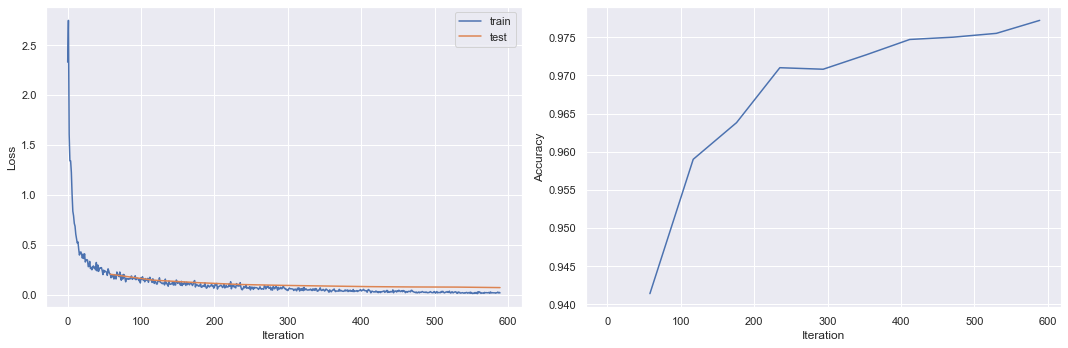

In [14]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, torch.optim.AdamW(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model.state_dict(), "../data/model_optimized_with_adam.pt")

Epoch: 0 	 Training loss: 0.1684076339006424 	 Test loss: 0.20472891628742218 	 Test accurarcy: 0.9386000037193298
Epoch: 1 	 Training loss: 0.16922692954540253 	 Test loss: 0.14377225935459137 	 Test accurarcy: 0.9573000073432922
Epoch: 2 	 Training loss: 0.08614609390497208 	 Test loss: 0.1112934947013855 	 Test accurarcy: 0.9667999744415283
Epoch: 3 	 Training loss: 0.07451421022415161 	 Test loss: 0.09929826110601425 	 Test accurarcy: 0.9678999781608582
Epoch: 4 	 Training loss: 0.08693430572748184 	 Test loss: 0.08996297419071198 	 Test accurarcy: 0.9722999930381775
Epoch: 5 	 Training loss: 0.054185736924409866 	 Test loss: 0.08639092743396759 	 Test accurarcy: 0.9729999899864197
Epoch: 6 	 Training loss: 0.025567246600985527 	 Test loss: 0.07529931515455246 	 Test accurarcy: 0.9767000079154968
Epoch: 7 	 Training loss: 0.02838357724249363 	 Test loss: 0.07494470477104187 	 Test accurarcy: 0.9781000018119812
Epoch: 8 	 Training loss: 0.040718574076890945 	 Test loss: 0.0759914070

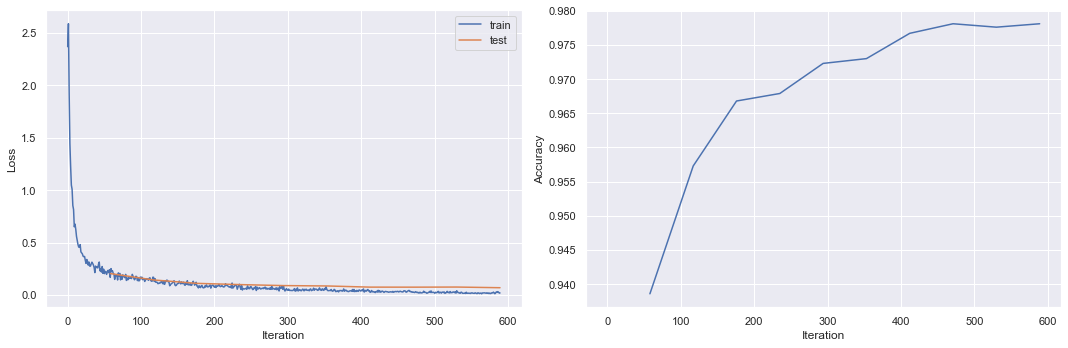

In [15]:
class AdamOptimizer(Optimizer):
    def __init__(self, parameters, lr, beta1 = 0.9, beta2 = 0.999, epsilon=1e-8, wd=1e-2):
        self.parameters, self.lr, self.beta1, self.beta2, self.epsilon, self.wd = list(parameters), lr, beta1, beta2, epsilon, wd
        self.t, self.state = 0, [{"m": 0., "v": 0.} for _ in self.parameters]
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for s, p in zip(self.state, self.parameters):
                p.mul_(1-self.lr*self.wd)
                s["m"] = self.beta1 * s["m"] + (1-self.beta1)*p.grad
                s["v"] = self.beta2 * s["v"] + (1-self.beta2)*p.grad.pow(2)
                p += - self.lr * math.sqrt(1-self.beta2**self.t) / (1 - self.beta1**self.t) * s["m"] / (s["v"].sqrt() + self.epsilon)
                
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, AdamOptimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model.state_dict(), "../data/model_optimized_with_adam.pt")

Epoch: 0 	 Training loss: 0.8342254161834717 	 Test loss: 0.7893980741500854 	 Test accurarcy: 0.8445000052452087
Epoch: 1 	 Training loss: 0.3636038899421692 	 Test loss: 0.31978973746299744 	 Test accurarcy: 0.9093000292778015
Epoch: 2 	 Training loss: 0.2570863962173462 	 Test loss: 0.24741032719612122 	 Test accurarcy: 0.9254999756813049
Epoch: 3 	 Training loss: 0.24326156079769135 	 Test loss: 0.1817629039287567 	 Test accurarcy: 0.9466999769210815
Epoch: 4 	 Training loss: 0.16546772420406342 	 Test loss: 0.1571955680847168 	 Test accurarcy: 0.951200008392334
Epoch: 5 	 Training loss: 0.09716589748859406 	 Test loss: 0.1278284192085266 	 Test accurarcy: 0.9591000080108643
Epoch: 6 	 Training loss: 0.07105228304862976 	 Test loss: 0.11073785275220871 	 Test accurarcy: 0.9664999842643738
Epoch: 7 	 Training loss: 0.05603214353322983 	 Test loss: 0.09469287842512131 	 Test accurarcy: 0.9718000292778015
Epoch: 8 	 Training loss: 0.057119984179735184 	 Test loss: 0.08916130661964417 

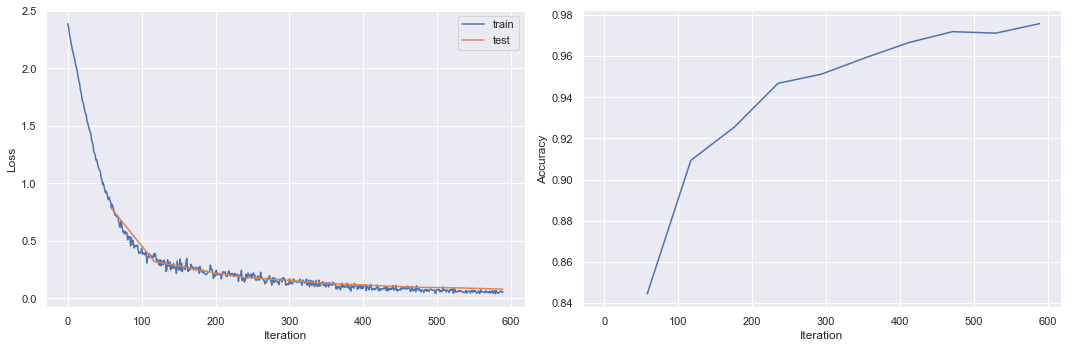

In [13]:
class LambOptimizer(Optimizer):
    def __init__(self, parameters, lr, beta1 = 0.9, beta2 = 0.999, epsilon=1e-8, wd=1e-2):
        self.parameters, self.lr, self.beta1, self.beta2, self.epsilon, self.wd = list(parameters), lr, beta1, beta2, epsilon, wd
        self.t, self.state = 0, [{"m": 0., "v": 0.} for _ in self.parameters]
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for s, p in zip(self.state, self.parameters):
                s["m"] = self.beta1 * s["m"] + (1-self.beta1)*p.grad
                s["v"] = self.beta2 * s["v"] + (1-self.beta2)*p.grad.pow(2)
                
                r = s["m"] / (s["v"].sqrt() + self.epsilon)* math.sqrt(1-self.beta2**self.t) / (1 - self.beta1**self.t)
                scale = r + self.wd*p
                p += - self.lr * scale * torch.norm(p).clamp(0., 10.) / torch.norm(scale)
                
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, LambOptimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model.state_dict(), "../data/model_optimized_with_lamb.pt")

## Exercise 2:

What other API is exposed by the `torch.optim` package?

In [11]:
# TODO: Exercise 2

# Anwser is _LRScheduler

## Section summary

The `torch.optim` package provides useful APIs and state-of-the-art algorithms for performing weight updates and learning rate scheduling.